In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lowan li
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset


100%|██████████| 121M/121M [00:07<00:00, 17.7MB/s]


<ipython-input-7-f801c8a4f77b>:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


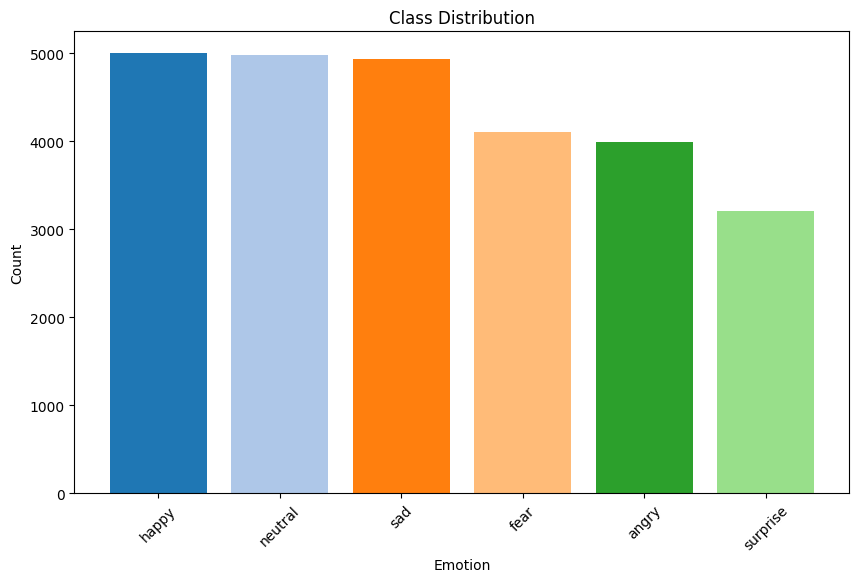

In [7]:
import os
import cv2
import random
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Assuming train_path is defined and contains the path to your training images

train_images = []
train_labels = []

# Load and preprocess images
for emotions in os.listdir(train_path):
    emotion_path = os.path.join(train_path, emotions)
    for file in os.listdir(emotion_path):
        image_path = os.path.join(emotion_path, file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        train_images.append(image)
        train_labels.append(emotions)

# Remove 'disgust' class
train_images = [img for img, lbl in zip(train_images, train_labels) if lbl != 'disgust']
train_labels = [lbl for lbl in train_labels if lbl != 'disgust']

# Down-sample 'happy' class to 5000 images
happy_indices = [i for i, lbl in enumerate(train_labels) if lbl == 'happy']
down_sampled_happy_indices = random.sample(happy_indices, 5000)
train_images = [img for i, img in enumerate(train_images) if train_labels[i] != 'happy' or i in down_sampled_happy_indices]
train_labels = [lbl for i, lbl in enumerate(train_labels) if lbl != 'happy' or i in down_sampled_happy_indices]

# Plot new class distribution
class_counts = {label: train_labels.count(label) for label in set(train_labels)}
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))
cmap = get_cmap('tab20')
colors = [cmap(i) for i in range(len(sorted_class_counts))]

plt.figure(figsize=(10, 6))
plt.bar(sorted_class_counts.keys(), sorted_class_counts.values(), color=colors)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

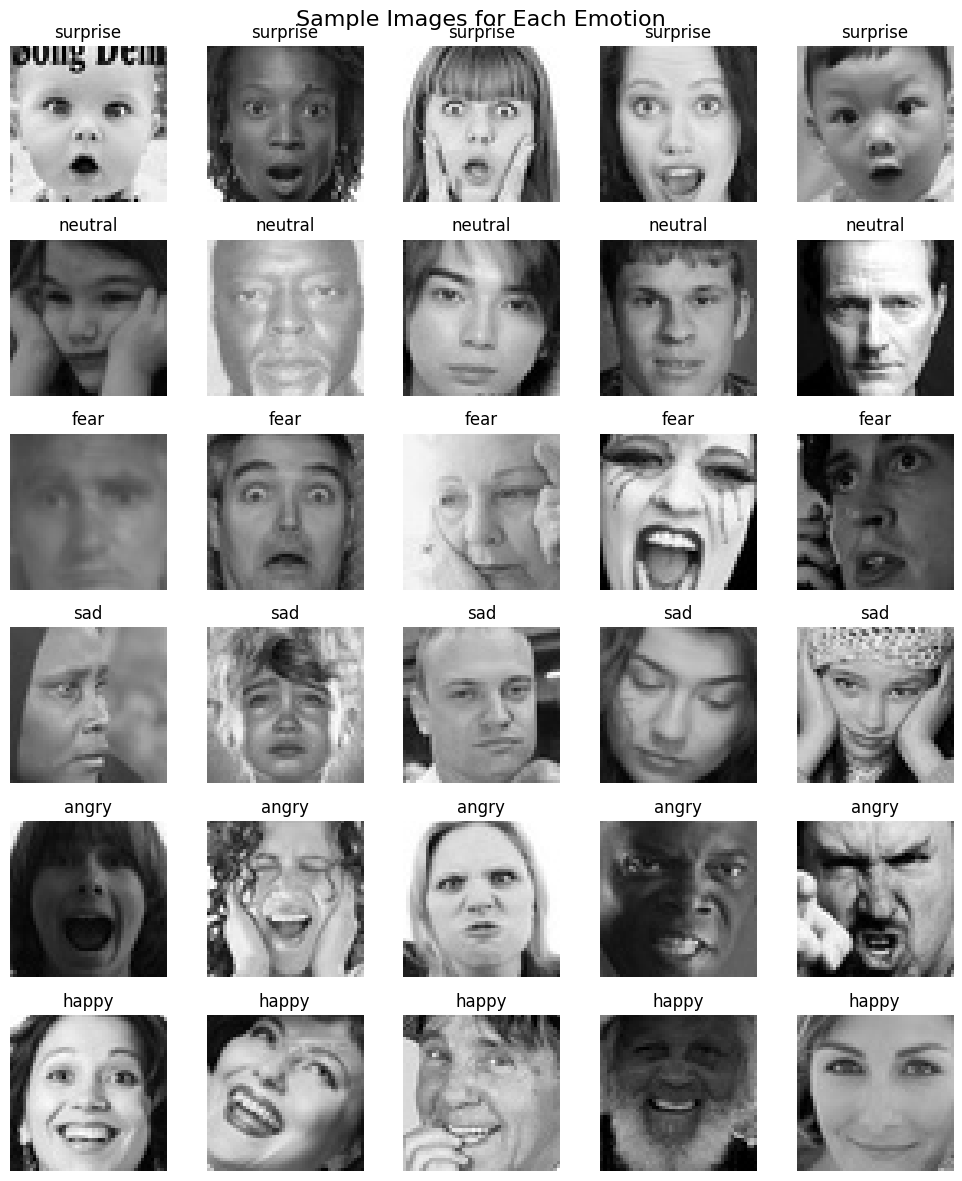

In [8]:
import matplotlib.pyplot as plt

# Function to visualize sample images for each emotion
def visualize_samples(images, labels, num_samples=5):
    unique_labels = list(set(labels))
    fig, axes = plt.subplots(len(unique_labels), num_samples, figsize=(num_samples * 2, len(unique_labels) * 2))
    fig.suptitle('Sample Images for Each Emotion', fontsize=16)

    for i, label in enumerate(unique_labels):
        label_indices = [idx for idx, lbl in enumerate(labels) if lbl == label]
        sample_indices = random.sample(label_indices, num_samples)
        for j, idx in enumerate(sample_indices):
            ax = axes[i, j] if len(unique_labels) > 1 else axes[j]
            ax.imshow(images[idx])
            ax.set_title(label)
            ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Visualize sample images
visualize_samples(train_images, train_labels)

In [9]:
import os
import cv2
import random
import shutil
import numpy as np

train_path = "/content/face-expression-recognition-dataset/images/train"
validation_path = "/content/face-expression-recognition-dataset/images/validation"

train_images = []
train_labels = []
validation_images = []
validation_labels = []

# Function to load images and labels, excluding the 'disgust' category
def load_images_and_labels(path, images_list, labels_list):
    for emotion in os.listdir(path):
        if emotion == 'disgust':
            continue
        emotion_path = os.path.join(path, emotion)
        for file in os.listdir(emotion_path):
            image_path = os.path.join(emotion_path, file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images_list.append(image)
            labels_list.append(emotion)

# Load training data
load_images_and_labels(train_path, train_images, train_labels)

# Load validation data
load_images_and_labels(validation_path, validation_images, validation_labels)

# Balance the training data
def balance_training_data(images, labels):
    balanced_images = []
    balanced_labels = []

    # Remove 'disgust' class
    for image, label in zip(images, labels):
        if label != 'disgust':
            balanced_images.append(image)
            balanced_labels.append(label)

    # Down-sample 'happy' class to 5000 images
    happy_indices = [i for i, lbl in enumerate(balanced_labels) if lbl == 'happy']
    down_sampled_happy_indices = random.sample(happy_indices, 5000)
    down_sampled_indices = set(down_sampled_happy_indices)

    final_images = []
    final_labels = []
    for i, (image, label) in enumerate(zip(balanced_images, balanced_labels)):
        if label != 'happy' or i in down_sampled_indices:
            final_images.append(image)
            final_labels.append(label)

    return final_images, final_labels

train_images, train_labels = balance_training_data(train_images, train_labels)


In [10]:
# Temporary directories for balanced data
temp_train_dir = '/content/temp_balanced_train'
temp_val_dir = '/content/temp_balanced_val'

# Function to save images to directories
def save_images_to_dir(images, labels, base_dir):
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir)
    os.makedirs(base_dir)

    for label in set(labels):
        os.makedirs(os.path.join(base_dir, label))

    for img, lbl in zip(images, labels):
        img_path = os.path.join(base_dir, lbl, f'{random.randint(0, 1e7)}.jpg')
        cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

# Save balanced training data
save_images_to_dir(train_images, train_labels, temp_train_dir)

# Save validation data
save_images_to_dir(validation_images, validation_labels, temp_val_dir)


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generators with augmentation for training data and rescaling for validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training and validation sets
train_generator = train_datagen.flow_from_directory(
    temp_train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    temp_val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Verify if the generators are working correctly
print(f"Found {train_generator.samples} images belonging to {train_generator.num_classes} classes in training data.")
print(f"Found {validation_generator.samples} images belonging to {validation_generator.num_classes} classes in validation data.")


Found 26216 images belonging to 6 classes.
Found 6955 images belonging to 6 classes.
Found 26216 images belonging to 6 classes in training data.
Found 6955 images belonging to 6 classes in validation data.


In [12]:
import tensorflow as tf

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Function to build VGG16 model for transfer learning
def build_vgg16_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall(),
                           F1Score()])
    return model

# Example usage
input_shape = (224, 224, 3)  # Adjust according to your image size
num_classes = train_generator.num_classes

vgg16_model = build_vgg16_model(input_shape, num_classes)

# Train the custom classifier
history = vgg16_model.fit(train_generator, validation_data=validation_generator, epochs=10, steps_per_epoch=len(train_images) // 32, validation_steps=len(validation_images) // 32)

# Optionally fine-tune some layers of the base model
for layer in vgg16_model.layers[-5:]:  # Unfreeze last 5 layers of the base model
    layer.trainable = True

vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                    loss='categorical_crossentropy',
                    metrics=['accuracy',
                             tf.keras.metrics.Precision(),
                             tf.keras.metrics.Recall(),
                             F1Score()])
fine_tune_history = vgg16_model.fit(train_generator, validation_data=validation_generator, epochs=10, steps_per_epoch=len(train_images) // 32, validation_steps=len(validation_images) // 32)



58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/10
819/819 [==============================] - ETA: 0s - loss: 1.6916 - accuracy: 0.2851 - precision: 0.6052 - recall: 0.0133 - f1_score: 0.0260

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


819/819 [==============================] - 303s 360ms/step - loss: 1.6916 - accuracy: 0.2851 - precision: 0.6052 - recall: 0.0133 - f1_score: 0.0260 - val_loss: 1.7383 - val_accuracy: 0.2641 - val_precision: 0.4947 - val_recall: 0.0537 - val_f1_score: 0.0969
Epoch 2/10
819/819 [==============================] - 296s 361ms/step - loss: 1.6341 - accuracy: 0.3204 - precision: 0.6040 - recall: 0.0326 - f1_score: 0.0619 - val_loss: 1.5866 - val_accuracy: 0.3504 - val_precision: 0.6378 - val_recall: 0.0563 - val_f1_score: 0.1035
Epoch 3/10
819/819 [==============================] - 295s 360ms/step - loss: 1.6090 - accuracy: 0.3346 - precision: 0.6427 - recall: 0.0461 - f1_score: 0.0860 - val_loss: 1.5588 - val_accuracy: 0.3750 - val_precision: 0.7152 - val_recall: 0.0488 - val_f1_score: 0.0914
Epoch 4/10
819/819 [==============================] - 296s 362ms/step - loss: 1.5975 - accuracy: 0.3441 - precision: 0.6256 - recall: 0.0541 - f1_score: 0.0996 - val_loss: 1.6173 - val_accuracy: 0.3223

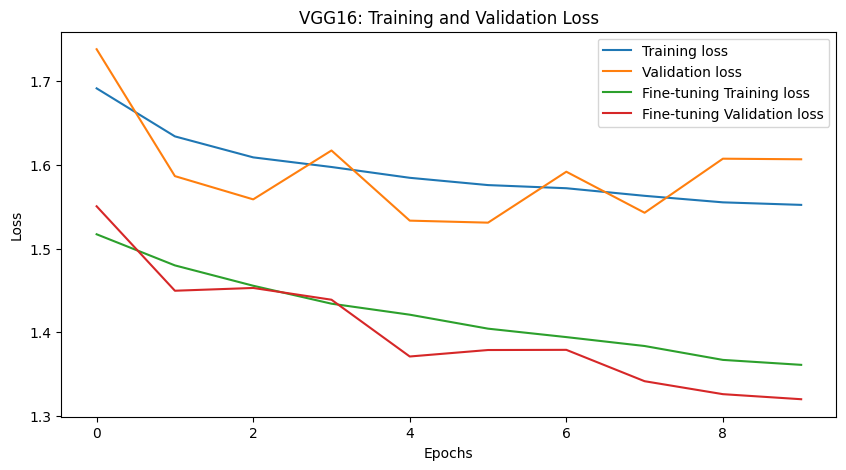

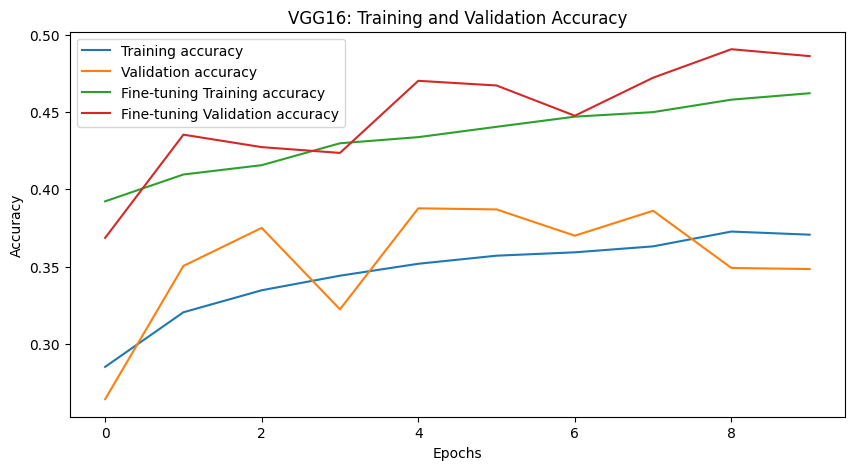

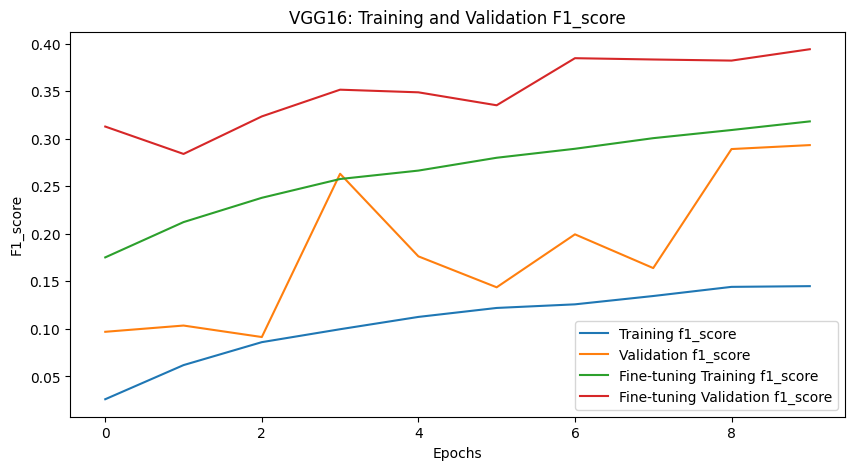

In [17]:
# Plotting function
def plot_metrics(history, fine_tune_history=None):
    metrics = ['loss', 'accuracy', 'f1_score']
    for metric in metrics:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        if fine_tune_history:
            plt.plot(fine_tune_history.history[metric], label=f'Fine-tuning Training {metric}')
            plt.plot(fine_tune_history.history[f'val_{metric}'], label=f'Fine-tuning Validation {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.title(f'VGG16: Training and Validation {metric.capitalize()}')
        plt.legend()
        plt.show()

# Plot metrics
plot_metrics(history, fine_tune_history)


In [18]:
from tensorflow.keras.applications import ResNet50

# Function to build ResNet50 model for transfer learning
def build_resnet50_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall(),
                           F1Score()])
    return model

# Example usage
resnet50_model = build_resnet50_model(input_shape, num_classes)

# Train the custom classifier
history1 = resnet50_model.fit(train_generator, validation_data=validation_generator, epochs=10, steps_per_epoch=len(train_images) // 32, validation_steps=len(validation_images) // 32, verbose=1)

# Optionally fine-tune some layers of the base model
for layer in resnet50_model.layers[-5:]:  # Unfreeze last 5 layers of the base model
    layer.trainable = True

resnet50_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy',
                                tf.keras.metrics.Precision(),
                                tf.keras.metrics.Recall(),
                                F1Score()])
fine_tune_history1 = resnet50_model.fit(train_generator, validation_data=validation_generator, epochs=10, steps_per_epoch=len(train_images) // 32, validation_steps=len(validation_images) // 32, verbose=1)




Epoch 1/10
819/819 [==============================] - ETA: 0s - loss: 1.8135 - accuracy: 0.1920 - precision_6: 0.2105 - recall_6: 6.1106e-04 - f1_score: 0.0012

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


819/819 [==============================] - 291s 351ms/step - loss: 1.8135 - accuracy: 0.1920 - precision_6: 0.2105 - recall_6: 6.1106e-04 - f1_score: 0.0012 - val_loss: 1.7668 - val_accuracy: 0.2631 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/10
819/819 [==============================] - 288s 351ms/step - loss: 1.7771 - accuracy: 0.1916 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 1.7678 - val_accuracy: 0.1830 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/10
819/819 [==============================] - 285s 348ms/step - loss: 1.7723 - accuracy: 0.1943 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 1.7669 - val_accuracy: 0.1730 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/10
819/819 [==============================] - 285s 348ms/step - loss: 1.7715 - accuracy: 0.1957 - precisi

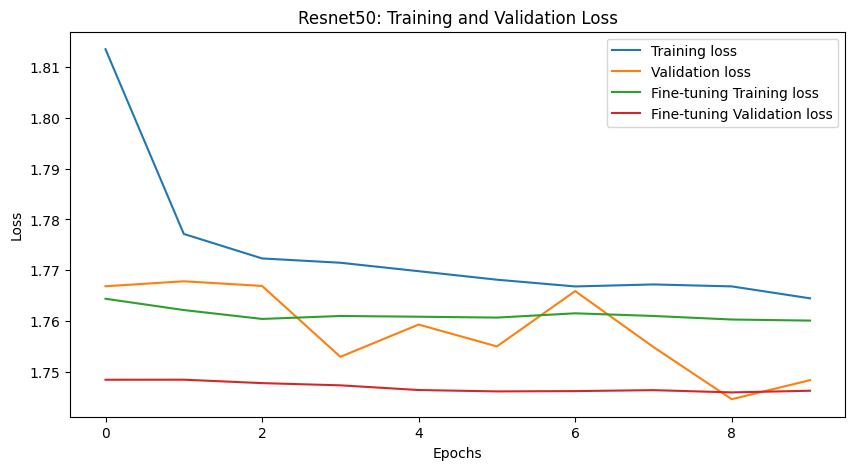

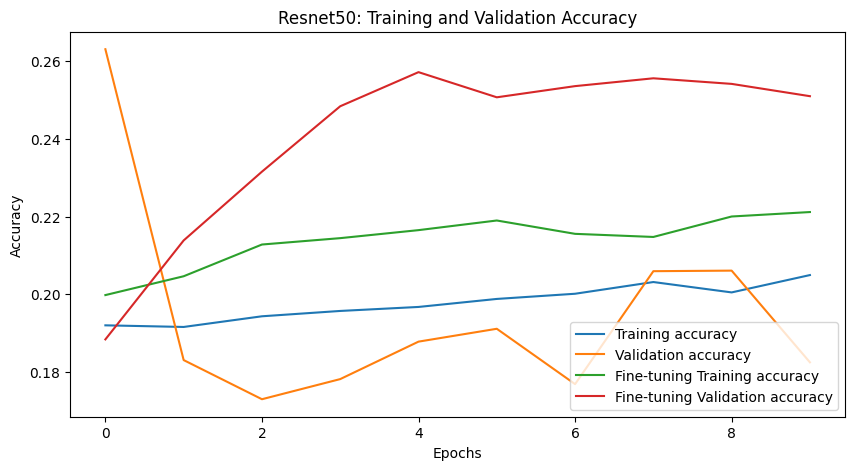

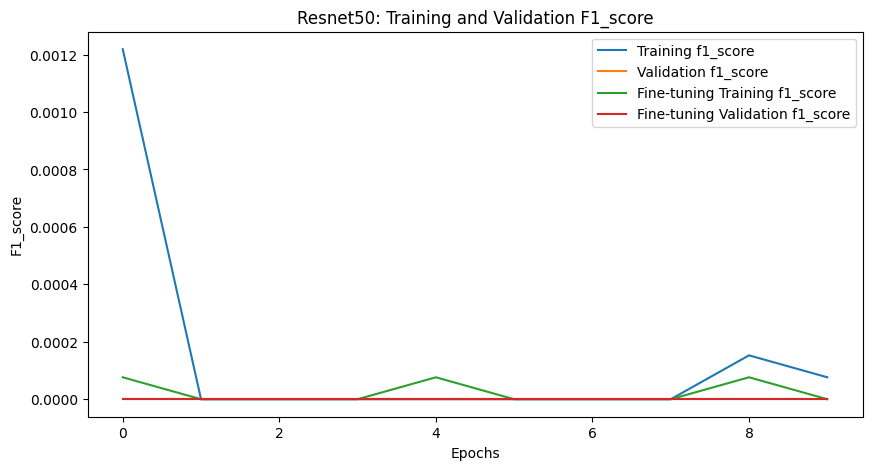

In [19]:
# Plotting function
def plot_metrics(history, fine_tune_history=None):
    metrics = ['loss', 'accuracy', 'f1_score']
    for metric in metrics:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        if fine_tune_history:
            plt.plot(fine_tune_history.history[metric], label=f'Fine-tuning Training {metric}')
            plt.plot(fine_tune_history.history[f'val_{metric}'], label=f'Fine-tuning Validation {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.title(f'Resnet50: Training and Validation {metric.capitalize()}')
        plt.legend()
        plt.show()

# Plot metrics
plot_metrics(history1, fine_tune_history1)


In [23]:
import pandas as pd
# Function to extract metrics into a DataFrame
def extract_metrics_to_df(history, fine_tune_history=None):
    metrics = ['loss', 'accuracy', 'f1_score']
    data = {}

    for metric in metrics:
        data[f'Training {metric}'] = history.history[metric]
        data[f'Validation {metric}'] = history.history[f'val_{metric}']
        if fine_tune_history:
            data[f'Fine-tuning Training {metric}'] = fine_tune_history.history[metric]
            data[f'Fine-tuning Validation {metric}'] = fine_tune_history.history[f'val_{metric}']

    epochs = range(1, len(history.history['loss']) + 1)
    df = pd.DataFrame(data, index=epochs)
    return df

# Extract metrics to DataFrame
metrics_df = extract_metrics_to_df(history, fine_tune_history)

# Print metrics DataFrame
print(metrics_df)

    Training loss  Validation loss  Fine-tuning Training loss  \
1        1.691553         1.738348                   1.517092   
2        1.634133         1.586613                   1.479873   
3        1.609042         1.558828                   1.455555   
4        1.597529         1.617263                   1.434092   
5        1.584609         1.533397                   1.420937   
6        1.575899         1.530984                   1.404238   
7        1.572140         1.591883                   1.394151   
8        1.563068         1.542821                   1.383496   
9        1.555265         1.607453                   1.366893   
10       1.552234         1.606753                   1.360972   

    Fine-tuning Validation loss  Training accuracy  Validation accuracy  \
1                      1.550557           0.285060             0.264113   
2                      1.449583           0.320386             0.350374   
3                      1.452895           0.334632         

In [24]:
# Extract metrics to DataFrame
metrics_df1 = extract_metrics_to_df(history1, fine_tune_history1)

# Print metrics DataFrame
print(metrics_df1)

    Training loss  Validation loss  Fine-tuning Training loss  \
1        1.813536         1.766833                   1.764370   
2        1.777145         1.767812                   1.762148   
3        1.772316         1.766899                   1.760397   
4        1.771466         1.752932                   1.760978   
5        1.769803         1.759289                   1.760834   
6        1.768126         1.754979                   1.760663   
7        1.766798         1.765884                   1.761504   
8        1.767192         1.754851                   1.760980   
9        1.766808         1.744577                   1.760280   
10       1.764456         1.748335                   1.760069   

    Fine-tuning Validation loss  Training accuracy  Validation accuracy  \
1                      1.748412           0.191987             0.263105   
2                      1.748423           0.191567             0.183036   
3                      1.747750           0.194317         

In [25]:
resnet50_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [26]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     